In [13]:
!nvidia-smi
!pip install pandas

Thu Feb 24 16:35:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-PCI...  Off  | 00000000:01:00.0 Off |                    0 |
| N/A   29C    P0    46W / 250W |  27018MiB / 40536MiB |     39%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-PCI...  Off  | 00000000:C1:00.0 Off |                    0 |
| N/A   

In [14]:
#Application of attention model with PTB dataset lead II
#modified by FSB
# * ***** 20211209 *FSB* USING convolution in front of LSTM to extract features and feed it to lstm gives an initial accuracy of 99.50%
import numpy as np
import pandas as pd
import pywt
#import tensorflow as tf
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
#from tensorflow import keras
from torch import nn
from torch.utils.data import DataLoader , TensorDataset
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import copy
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
from torchinfo import summary

from datetime import datetime
#from tensorflow.keras import regularizers
#from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import torch
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import sklearn
import itertools
#from tensorflow_addons.optimizers import CyclicalLearningRate
#from tensorflow.keras.layers import LSTM,Bidirectional,Flatten

Using cuda device
TEST


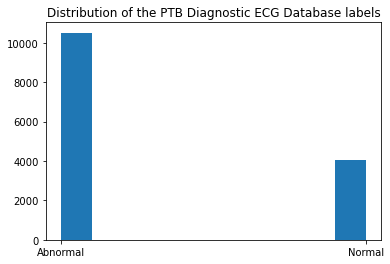

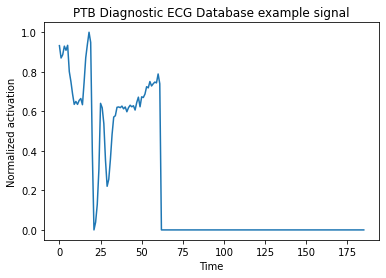

In [15]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))


import matplotlib as mpl
#mitbih_test = pd.read_csv("/tmp/ecg/mitbih_test.csv", header=None)
#mitbih_train = pd.read_csv("/tmp/ecg/mitbih_train.csv", header=None)
ptbdb_abnormal = pd.read_csv("ptbdb_abnormal.csv", header=None)
ptbdb_normal = pd.read_csv("ptbdb_normal.csv", header=None)
ptbdb = pd.concat([ptbdb_abnormal, ptbdb_normal], axis=0, ignore_index=True)
ptbdb_abnormal.values[:,-1]
ptbdb_labels = {'Normal': 0, 'Abnormal': 1}
print('TEST')
ptbdb_reverse_labels = {v:k for k,v in ptbdb_labels.items()}
ptbdb_labels = ptbdb.iloc[:,-1].replace(ptbdb_reverse_labels)
plt.hist(ptbdb_labels)
plt.title("Distribution of the PTB Diagnostic ECG Database labels")
plt.show()
plt.plot(ptbdb.iloc[0,:-2])
plt.xlabel('Time')
plt.ylabel('Normalized activation')
plt.title("PTB Diagnostic ECG Database example signal")
plt.show()

In [16]:
# Reproducibility
# TODO check irreproducibilty with Cuda
# DOES NOT WORK ! os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:2'
#os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':16:8'
#RANDOM_SEED = 42
#torch.manual_seed(RANDOM_SEED)
#np.random.seed(RANDOM_SEED)
#torch.cuda.manual_seed(RANDOM_SEED)
#torch.cuda.manual_seed_all(RANDOM_SEED)
#torch.backends.cudnn.deterministic = True
#torch.backends.cudnn.benchmark = False

In [17]:
def compute_dwt(X):  
    res = []
    for x in X:   
        #print(x.shape)
            coeffs = pywt.wavedec(x, 'db5', level=2) 
        #x = smooth(x, level=4)
        #coeffs = pywt.wavedec(x, 'sym6', level=4) 
        cA2, cD2, cD1 = coeffs
        #cA1, cD1 = coeffs
        #print(cD1.shape)
        #interleaved = [val for pair in zip(cA4, cD4) for val in pair]
        #res.append(torch.from_numpy(interleaved)))
        res.append(torch.from_numpy(np.concatenate([cA2, cD1, cD2], axis=2)))
        #print(torch.from_numpy(np.concatenate([cA1, cD1])).shape)
        #res.append(torch.from_numpy(cA1))        
        #print(cA1.shape)
        #print(len(cD3))
    tensors = torch.stack(res)
    print(tensors.shape)
    return(tensors)

In [18]:
# TOOO - must not hardcode
# takes input tensor and splits it into (17 hardcoded) chunks of smaller window size
# each is transformed using discrete wavelet tramsformation - we only keep cA component 
# TODO we could inlucde more components (also high frequency cDn's) and should use flexible levels
# This way, we create a dim embedding using the dimension n = number of cA's. 
#
# With the current hardcoded setup we reduce time steps from 187 to 17 but increase features from 1 to 28, 
# henceforth we map (14552, 1, 187) to (14552, 28, 17). This creates a dim_embedding of 28 which is high enough 
# to preserve information and enable grad descent for attention / transformer using also res connections, compare
# line x = x + self.transformer_encoder(x) (instead of x = self.transformer_encoder(x)) in transformer 
# forward method (TODO check whether still necessary)
#
# The dim_embedding of 28 is a result of taking coeffiecnts cA2, cD2, cD1 of 'db5', level=2, because
# len(cA2) = 14 and len(cD2) = len(cD1) = 7
#
# TODO check whether positional encoding is beneficial
#

def dim_embedding(x):
    #print(x.shape)

    chunks = torch.split(x, 11, dim=2)
    #print(len(chunks))

    # transform using dwt
    # skip last chunk because it is shorter

    chunks_dwt = torch.flatten(compute_dwt(chunks[0:18]), start_dim=2, end_dim=3)

    # reshape tensor to match batch x features x seq_length
    print(chunks_dwt.shape)
    chunks_dwt = chunks_dwt.permute(1, 2, 0)
    print(chunks_dwt.shape)    
    return chunks_dwt

In [19]:

NUM_FEATURES = 28
# For complex phase included, number of features doubles
# NUM_FEATURES = 232*2

#SEQ_LENGTH = 187#from shape the number of coloumns
SEQ_LENGTH = 17

# TODO must not hardcode
# BATCH_SIZE = 32
BATCH_SIZE = 256
LEARNING_RATE = 0.001
EPOCHS = 1000

encoder = preprocessing.LabelEncoder()

NUM_CLASSES = -1
X,y= ptbdb.iloc[:,:-1].values, ptbdb.iloc[:,-1].values,
print(X.shape)
print(y.shape)
def data2tensor(X, y, encoder):
    """convert rawdata and rawlabel with encoder to pytorch tensor

    Keyword arguments:
    rawdata -- np array of rawdata
    rawlabels -- np array of labels corresponding to rawdata
    encoder -- instance of LabelEncoder used for encoding

    Returns:
    tensor: torch.Tensor of type DoubleTensor with
            dimension [batch size (i.e. number of X instances), NUM_FEATURES, SEQ_LENGTH]
    """
    # labels as digit representation instead of letters
    encoder.fit(y)
    y = encoder.transform(y)
    #print('ANOTHER TEST')
    tensors = []
    labels = []
    for i in range(len(y)):
        #if X[i].shape == (NUM_FEATURES, SEQ_LENGTH):  # skip data with incorrect dimensions TODO: avoid hardcoding
            # r_tensor = torch.tensor(rawdata[i].real, device=device)
            # i_tensor = torch.tensor(rawdata[i].imag, device=device)
            # tensors.append(torch.cat((r_tensor, i_tensor), 0))

            # append the absolute value (TODO should be configurable)

            # ts_fft = sp.fftpack.fft(rawdata[i])
            # ts_psd = np.abs(ts_fft) ** 2
            # tensors.append(torch.tensor(ts_psd, device=device))
        tensors.append(torch.tensor(np.absolute(X[i]), device=device))
        labels.append(y[i])
    #tensors=np.array(tensors)
    #tensors=np.expand_dims(tensors,2)
    return torch.stack(tensors), torch.as_tensor(labels, device=device)

#rawdata, rawlabels = load_dataset(csi_data)
print('ANOTHER TEST')
data, labels = data2tensor(X, y, encoder)
print(data.type)
#data= data.argmax
data=data.cpu().numpy()

#data=np.array(data)
#print(data.shape)
#expanding dimensions to make it 3-D
print('Before')
#data=data.expand_dims(data,1)

data=np.expand_dims(data,1)
print(data.shape)
data = torch.tensor(data)
print(data.shape)
print("data.shape")
data = dim_embedding(data)
print("data.shape after")
print(data.shape)
mean = torch.mean(data)
std = torch.std(data)



from torchvision import transforms
normalize = transforms.Normalize(mean, std)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
nor_data = normalize(data).to(device)


dataset = TensorDataset(nor_data, labels)
#dataset = TensorDataset(data, labels)
#dataset = dataset.to(device=torch.device("cuda:0"))
print('ANOTHER TEST')
NUM_CLASSES = len(encoder.classes_)
print(NUM_CLASSES)
# split data into training, validation, and test (todo: make better configurable)
full_size = int(len(dataset))
train_size = int(0.8 * full_size)
val_size = (len(dataset) - train_size)//2
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, full_size - train_size-val_size], generator=torch.Generator().manual_seed(4))

dataloader_train = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, generator=torch.Generator())
dataloader_val = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, generator=torch.Generator())
dataloader_test = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, generator=torch.Generator())


(14552, 187)
(14552,)
ANOTHER TEST
<built-in method type of Tensor object at 0x7f65908e5e30>
Before
(14552, 1, 187)
torch.Size([14552, 1, 187])
data.shape
torch.Size([17, 14552, 1, 28])
torch.Size([17, 14552, 28])
torch.Size([14552, 28, 17])
data.shape after
torch.Size([14552, 28, 17])
ANOTHER TEST
2


In [20]:
len(test_dataset)

1456

In [21]:
data.shape

torch.Size([14552, 28, 17])

In [22]:


print('AFTER dataloading')
print(dataloader_train)
print(dataloader_val)
print(dataloader_test)
#X_ptbdb_train, X_ptbdb_val, y_ptbdb_train, y_ptbdb_val = train_test_split(ptbdb.iloc[:,:-1].values, ptbdb.iloc[:,-1].values, test_size=0.2, random_state=42)
#X_ptbdb_val, X_ptbdb_test, y_ptbdb_val, y_ptbdb_test  = train_test_split(X_ptbdb_val, y_ptbdb_val, test_size=0.5, random_state=42)
print('AFTER DIVISION')
#print(X_ptbdb_train.shape)

#print(X_ptbdb_val.shape)
print(len(dataloader_val))
print(len(dataloader_test))
print(data.shape)
print(data.type())

class CNN(nn.Module):
    """CNN - to be used to front-end transformer. Not used currently. TODO: adopt the dimensions properly"""
    def __init__(self, seq_length, feature_length):
        super(CNN, self).__init__()

        self.seq_length = seq_length
        self.feature_length = feature_length

        #todo not hardcode
        self.hiddenLast=18
        self.hidden1=64

        self.kernel_size=1

        self.activation=nn.ReLU()

        self.first=True

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=self.hidden1, kernel_size=self.kernel_size),
            nn.BatchNorm2d(num_features=self.hidden1),
            self.activation,
            #nn.MaxPool1d(kernel_size=2)
        )

        self.convLast = nn.Sequential(
            nn.Conv2d(in_channels=self.hidden1, out_channels=self.hiddenLast, kernel_size=self.kernel_size),
            nn.BatchNorm2d(num_features=self.hiddenLast),
            self.activation,
            nn.Dropout(),
            nn.MaxPool2d(kernel_size=1)
        )
        self.fl = nn.Flatten()
        #TODO must not hardcode number of layers (2)
        #
        # weight x height (weight and height are reducted by self.kernel_size-1 each time conv and 1/4 factor due to max pool 2d)
        #num_features = (self.feature_length - 2*(self.kernel_size-1)) * (self.seq_length - 2*(self.kernel_size-1)) * self.hiddenLast / 4
        #self.fc = nn.Linear(in_features=int(num_features), out_features=NUM_CLASSES)


    def forward(self, x):
        print(x.shape)
        # torch expects channel = 1
        x = x.to(device=torch.device("cuda:0"))
        x = x.unsqueeze(1)
        #print(x.shape)
        x = self.conv1(x)

        #x = x.squeeze(1)
        x = self.convLast(x)

        #print(x.shape)
        x = self.fl(x)
        #x = self.fc(x)
        #print(x.shape)

        nn.Flatten()
        if self.first:
            print(x.size())
            self.first=False
        return x
class TransformerModel(nn.Module):
    """Main TransformerModel used

    Attributes
    ----------
    dmodel : itensor
        input tensor
    seq_len : int
        length of sequence (time dim)
    nhead : int
        number of heads in nn.MultiheadAttention
    d_hid : int
        dimension of the feedforward network model in nn.TransformerEncoder
    nlayers : int
        number of nn.TransformerEncoderLayer in nn.TransformerEncoder
    """

    def __init__(self, dmodel, seq_len, nhead, d_hid, nlayers):
        super().__init__()
        self.dmodel = dmodel
        self.seq_len = seq_len
        #self.cnn = CNN(seq_length = seq_len, feature_length = NUM_CLASSES)
        self.pos_encoder = PositionalEncoding(dmodel, seq_len)
        encoder_layers = TransformerEncoderLayer(dmodel, nhead, d_hid)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        # TODO: Must not hardcode dropout
        self.dropout = nn.Dropout(p=0.0)
        self.fc = nn.Linear(in_features=seq_len * dmodel, out_features=NUM_CLASSES)

    def forward(self, x):
        # x = self.cnn(x)
        # 3d: batch, embedding_dim, seq_len
        #print('SHAPE OF X')
        x = x.permute(2, 0, 1)
        #x=x.permute()        
        # 3d: seq_len, batch_size, embedding_dim
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        #x = self.dropout(x)
        # 3d: seq_len, batch_size, features
        #x = x.permute(1, 0, 2)
        x = x.permute(1, 2, 0)
        # print(x.shape)
        # 3d: batch_size, seq_len,features
        x = x.reshape(-1, self.seq_len * self.dmodel)
        #x = x.reshape(self.seq_len * self.dmodel)
        # 2d: batch_size, seq_len*features
        return self.fc(x)


# from pytorch website https://pytorch.org/tutorials/beginner/transformer_tutorial.html
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, seq_len):
        super().__init__()

        self.d_model = d_model
        # pos = torch.arange(seq_len).unsqueeze(1)
        # every_second_dim = torch.arange(start=0, end=d_model, step=2)
        # TODO must not hardcode
        # frequency =10000.0
        frequency = 10000.0
        # div_term = frequency ** (every_second_dim / d_model)
        # pe = torch.zeros(seq_len, 1, d_model)

        # pe[:, 0, 0::2] = torch.sin(pos / div_term)
        # pe[:, 0, 1::2] = torch.cos(pos / div_term)
        # self.register_buffer('pe', pe)

        position = torch.arange(seq_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-np.log(frequency) / d_model))
        pe = torch.zeros(seq_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # make embeddings relatively larger
        # print(self.d_model)
        # x = x * np.sqrt(self.d_model)
        # x = x * self.d_model

        # print(x.shape)
        # print(torch.mean(x))
        # x = x + torch.mean(x)*self.pe[:x.size(0)]
        x = x.to(device=torch.device("cuda:0"))
        x = x + self.pe[:x.size(0)]
        # x = x + 5*self.pe[:x.size(0)]
        # return self.dropout(x)
        return x

def train_loop(dataloader, model, loss_fn, optimizer, epoch):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss = 0
    log_step = 10
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X.float())
        loss = loss_fn(pred, y)
        train_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % log_step == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    train_loss /= num_batches
    train_losses.append(train_loss.item())
    # For loss graph on tensorboard
    writer.add_scalar('Loss/Train', train_loss, epoch)


def validation_loop(dataloader, model, loss_fn, epoch):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    validation_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X.float())
            validation_loss += loss_fn(pred, y).item()
            #correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    validation_loss /= num_batches
    val_losses.append(validation_loss)
    correct /= size
    # For loss graph on tensorboard
    writer.add_scalar('Loss/Validation', validation_loss, epoch)
    print(f"Accuracy: {(100*correct):>0.2f}%, Avg loss: {validation_loss:>8f}")
    return (correct, validation_loss)

dmodel = 28
    #data.shape[1] # NUM_FEATURES
print('DATA SHAPE',data.shape[1])
d_hid = 250  # dimension of the feedforward network model in nn.TransformerEncoder
#nlayers = 2  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nlayers = 4  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 1  # number of heads in nn.MultiheadAttention
model = TransformerModel(dmodel, SEQ_LENGTH, nhead, d_hid, nlayers).to(device)
#model = CNN(seq_length = SEQ_LENGTH, feature_length = NUM_CLASSES).to(device)
# Add some tensorflow information
print('BEFO>rE')
#writer.add_graph(model, data.float()[0:1,])

# save graph to tensorflow
#writer.add_graph(model, data.float()[0:1,])

#print model summary for debugging
print(summary(model))
# empty loss arrays for clean performance figures
val_losses = []
train_losses = []

#model = LSTM(data.shape[2], data.shape[1]).to(device)
#model = CNN(data.shape[2], data.shape[1]).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_of_best_accuracy = float('inf')
best_accuracy = 0
best_model = None
best_epoch = 0

start_time = datetime.now()
for t in range(EPOCHS):
    print(f"\nEpoch {t+1}\n-------------------------------")
    train_loop(dataloader_train, model, loss_fn, optimizer, t+1)

    accuracy, loss = validation_loop(dataloader_val, model, loss_fn, t+1)
    # TODO: make "best model" strategy configurable
    #if loss < loss_of_best_accuracy:
    if accuracy > best_accuracy or (accuracy == best_accuracy and loss < loss_of_best_accuracy):
        best_accuracy = accuracy
        loss_of_best_accuracy = loss
        best_model = copy.deepcopy(model)
        best_epoch = t+1
        print('Model saved')
end_time = datetime.now()
print(f"\nDone! Validation accuracy: {(100*best_accuracy):>0.2f}%")
print(f"Training took {(end_time-start_time).total_seconds():>0.2f} seconds")

AFTER dataloading
AFTER DIVISION
6
6
torch.Size([14552, 28, 17])
torch.DoubleTensor
DATA SHAPE 28
BEFO>rE
Layer (type:depth-idx)                                            Param #
TransformerModel                                                  --
├─PositionalEncoding: 1-1                                         --
├─TransformerEncoder: 1-2                                         --
│    └─ModuleList: 2-1                                            --
│    │    └─TransformerEncoderLayer: 3-1                          17,638
│    │    └─TransformerEncoderLayer: 3-2                          17,638
│    │    └─TransformerEncoderLayer: 3-3                          17,638
│    │    └─TransformerEncoderLayer: 3-4                          17,638
├─Dropout: 1-3                                                    --
├─Linear: 1-4                                                     954
Total params: 61,762
Trainable params: 61,762
Non-trainable params: 0

Epoch 1
-------------------------------
lo

In [23]:
@torch.no_grad()
def predict(model, loader):
    # initialise empty tensors for predictions and targets
    all_preds = torch.tensor([], device=device, dtype=int)
    all_targets = torch.tensor([], device=device, dtype=int)
    model.eval()
    for batch in loader:
        data, labels = batch
        preds = model(data.float()).argmax(1)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
        all_targets = torch.cat((all_targets, labels.int()), dim=0)
    model.train()    
    return all_preds, all_targets


In [24]:
with torch.no_grad():
  predictions, targets = predict(best_model, dataloader_test)

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

accuracy_score(predictions.cpu(), targets.cpu())

0.9972527472527473

In [26]:
cm = confusion_matrix(targets.cpu(), predictions.cpu())

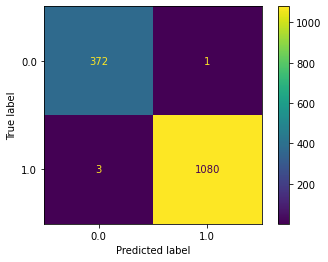

In [27]:
cmd = ConfusionMatrixDisplay(cm, display_labels=encoder.classes_)
cmd.plot()

In [28]:
cm_norm = np.transpose(np.transpose(cm) / cm.sum(axis=-1))

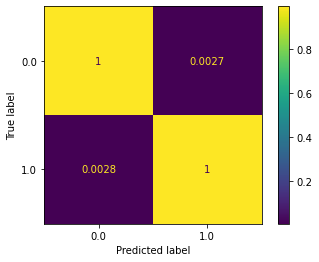

In [29]:
cmd_norm = ConfusionMatrixDisplay(cm_norm, display_labels=encoder.classes_)

cmd_norm.plot()

In [30]:
cm_norm

array([[0.99731903, 0.00268097],
       [0.00277008, 0.99722992]])

In [31]:
cm

array([[ 372,    1],
       [   3, 1080]])

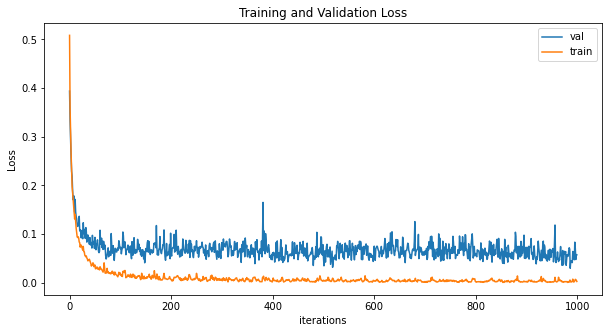

In [32]:
# Plot simple loss graph, see also tensorboard
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()